New classification task

In [1]:
# import exploratory data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE


# import scikit-learn modules
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import PCA

In [2]:
# load the dataset
df1 = pd.read_csv('fraud_detection.csv')

# examine df1
print(df1.shape, "\n")
print(df1.info())

(6362620, 11) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


In [3]:
# look at numeric columns
df1.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [4]:
# check for null and unique values
print(df1.isna().sum())
print("\n", df1.nunique().sort_values())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

 isFlaggedFraud          2
isFraud                 2
type                    5
step                  743
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
newbalanceDest    3555499
oldbalanceDest    3614697
amount            5316900
nameOrig          6353307
dtype: int64


In [5]:
# check distribution of target variable: isFraud
# check the balance of the isFraud column
fraud_counts = df1['isFraud'].value_counts()
fraud_ratio = df1['isFraud'].value_counts(normalize=True)

print("Count of each class in 'isFraud' column:")
print(fraud_counts)

print("\nRatio of each class in 'isFraud' column:")
print(fraud_ratio)

Count of each class in 'isFraud' column:
isFraud
0    6354407
1       8213
Name: count, dtype: int64

Ratio of each class in 'isFraud' column:
isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


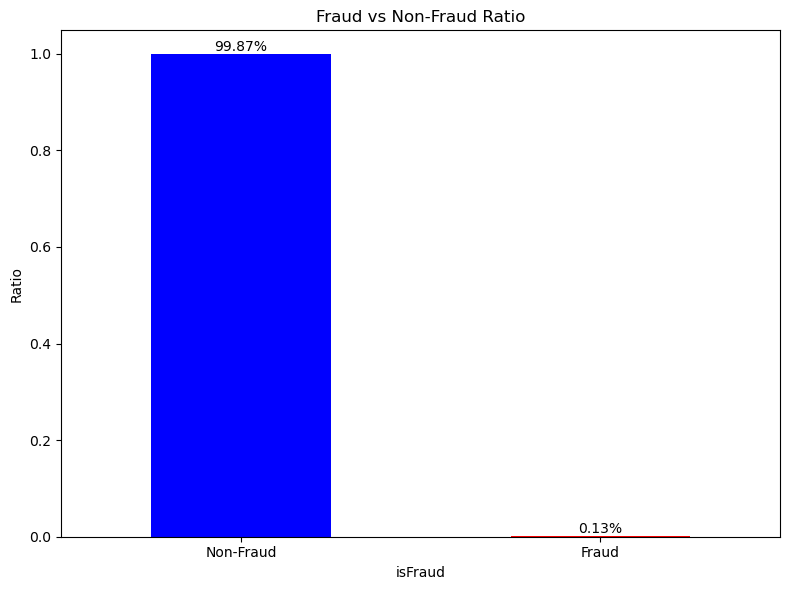

In [6]:
# create a bar chart of fraud_ratio
fig, ax = plt.subplots(figsize=(8, 6))

fraud_ratio.plot(kind='bar', ax=ax, color=['blue', 'red'])

# set labels and title
ax.set_ylabel('Ratio')
ax.set_title('Fraud vs Non-Fraud Ratio')
ax.set_xticklabels(['Non-Fraud', 'Fraud'], rotation=0)

# add percentage labels on the bars
for i, v in enumerate(fraud_ratio):
    ax.text(i, v, f'{v:.2%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [7]:
# examine balance of isFlaggedFraud column
flagged_fraud_counts = df1['isFlaggedFraud'].value_counts()
flagged_fraud_ratio = df1['isFlaggedFraud'].value_counts(normalize=True)

print("Count of each class in 'isFlaggedFraud' column:")
print(fraud_counts)

print("\nRatio of each class in 'isFlaggedFraud' column:")
print(fraud_ratio)

# drop duplicate target variable
df1 = df1.drop('isFlaggedFraud', axis=1)

Count of each class in 'isFlaggedFraud' column:
isFraud
0    6354407
1       8213
Name: count, dtype: int64

Ratio of each class in 'isFlaggedFraud' column:
isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64


In [8]:
# separate fraud and non-fraud cases
df_fraud = df1[df1['isFraud'] == 1]
df_non_fraud = df1[df1['isFraud'] == 0]

# sample from non-fraud cases
df_non_fraud_sampled = df_non_fraud.sample(frac=0.01, random_state=42)

# combine fraud cases with sampled non-fraud cases
df2 = pd.concat([df_fraud, df_non_fraud_sampled]).reset_index(drop=True)

# shuffle the resulting DataFrame
df2 = df2.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"Original shape: {df1.shape}")
print(f"New shape: {df2.shape}")
print(f"Fraud cases in original: {df1['isFraud'].sum()}")
print(f"Fraud cases in new: {df2['isFraud'].sum()}")

Original shape: (6362620, 10)
New shape: (71757, 10)
Fraud cases in original: 8213
Fraud cases in new: 8213


In [9]:
print(df2.shape)
print(df2.info())

(71757, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71757 entries, 0 to 71756
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            71757 non-null  int64  
 1   type            71757 non-null  object 
 2   amount          71757 non-null  float64
 3   nameOrig        71757 non-null  object 
 4   oldbalanceOrg   71757 non-null  float64
 5   newbalanceOrig  71757 non-null  float64
 6   nameDest        71757 non-null  object 
 7   oldbalanceDest  71757 non-null  float64
 8   newbalanceDest  71757 non-null  float64
 9   isFraud         71757 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 5.5+ MB
None


In [10]:
# check new balance of isFraud
fraud_counts = df2['isFraud'].value_counts()
fraud_ratio = df2['isFraud'].value_counts(normalize=True)

print("Count of each class in 'isFraud' column:")
print(fraud_counts)

print("\nRatio of each class in 'isFraud' column:")
print(fraud_ratio)

Count of each class in 'isFraud' column:
isFraud
0    63544
1     8213
Name: count, dtype: int64

Ratio of each class in 'isFraud' column:
isFraud
0    0.885544
1    0.114456
Name: proportion, dtype: float64


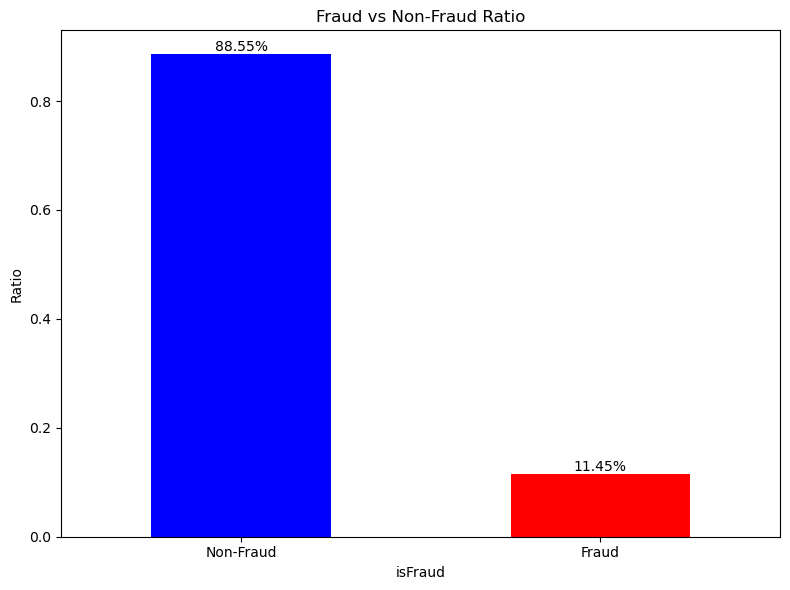

In [11]:
# create a new bar chart of fraud_ratio after taking a sample
fig, ax = plt.subplots(figsize=(8, 6))

fraud_ratio.plot(kind='bar', ax=ax, color=['blue', 'red'])

# set labels and title
ax.set_ylabel('Ratio')
ax.set_title('Fraud vs Non-Fraud Ratio')
ax.set_xticklabels(['Non-Fraud', 'Fraud'], rotation=0)

# add percentage labels on the bars
for i, v in enumerate(fraud_ratio):
    ax.text(i, v, f'{v:.2%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Categorical variables: type: 
1. type of online transaction;
2. nameOrig: name of customer starting transaction;
3. nameDest: name of customer receiving transaction.

nameOrig and nameDest may be predictive of fraud. However, they have a large number of unique values (as categorical variables). They are also unranked. So label encoding and one-hot encoding will not be meaningful.
Instead, I frequency encode nameOrig and nameDest based on how many times isFraud == 1, meaning the account has been flagged for fraud. This should be predictive and still retain the shape of the original data without creating thousands of extra columns, as one-hot encoding would.

'type' column only has 5 unique values, so I can hash or one-hot encode it.

In [12]:
# count the number of times each nameOrig has been involved in fraud
fraud_orig_counts = df2[df2['isFraud'] == 1]['nameOrig'].value_counts().to_dict()

# count the number of times each nameDest has been involved in fraud
fraud_dest_counts = df2[df2['isFraud'] == 1]['nameDest'].value_counts().to_dict()

# create new features in the original dataframe
df2['nameOrig_fraud_count'] = df2['nameOrig'].map(fraud_orig_counts).fillna(0).astype(int)
df2['nameDest_fraud_count'] = df2['nameDest'].map(fraud_dest_counts).fillna(0).astype(int)

# drop old columns
df3 = df2.copy()
df3.drop(columns=['nameOrig', 'nameDest'])

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,nameOrig_fraud_count,nameDest_fraud_count
0,644,CASH_OUT,135158.41,51665.00,0.00,0.00,135158.41,0,0,0
1,308,PAYMENT,37073.74,0.00,0.00,0.00,0.00,0,0,0
2,507,TRANSFER,2291498.65,2291498.65,0.00,0.00,0.00,1,1,1
3,142,PAYMENT,1996.09,944.00,0.00,0.00,0.00,0,0,0
4,12,CASH_OUT,377522.92,358789.32,0.00,502237.67,1057234.62,0,0,0
...,...,...,...,...,...,...,...,...,...,...
71752,395,PAYMENT,12109.73,283556.96,271447.23,0.00,0.00,0,0,0
71753,567,TRANSFER,122816.67,122816.67,0.00,0.00,0.00,1,1,1
71754,331,CASH_IN,52454.74,15651.00,68105.74,40203.40,0.00,0,0,0
71755,71,TRANSFER,1871553.73,1871553.73,0.00,0.00,0.00,1,1,1


In [13]:
# drop the 'nameOrig' and 'nameDest' columns
df3 = df3.drop(columns=['nameOrig', 'nameDest'])

# verify the columns have been dropped
print(df3.columns)

# examine the new features
print(df3.head())

Index(['step', 'type', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest', 'isFraud', 'nameOrig_fraud_count',
       'nameDest_fraud_count'],
      dtype='object')
   step      type      amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0   644  CASH_OUT   135158.41       51665.00             0.0            0.00   
1   308   PAYMENT    37073.74           0.00             0.0            0.00   
2   507  TRANSFER  2291498.65     2291498.65             0.0            0.00   
3   142   PAYMENT     1996.09         944.00             0.0            0.00   
4    12  CASH_OUT   377522.92      358789.32             0.0       502237.67   

   newbalanceDest  isFraud  nameOrig_fraud_count  nameDest_fraud_count  
0       135158.41        0                     0                     0  
1            0.00        0                     0                     0  
2            0.00        1                     1                     1  
3            0.00        0 

In [14]:
# one-hot encode the type column
df3 = pd.get_dummies(df3, columns=['type'])

In [15]:
# examine df3
print(df3.shape, "\n")
print(df3.info())

(71757, 14) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71757 entries, 0 to 71756
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   step                  71757 non-null  int64  
 1   amount                71757 non-null  float64
 2   oldbalanceOrg         71757 non-null  float64
 3   newbalanceOrig        71757 non-null  float64
 4   oldbalanceDest        71757 non-null  float64
 5   newbalanceDest        71757 non-null  float64
 6   isFraud               71757 non-null  int64  
 7   nameOrig_fraud_count  71757 non-null  int64  
 8   nameDest_fraud_count  71757 non-null  int64  
 9   type_CASH_IN          71757 non-null  bool   
 10  type_CASH_OUT         71757 non-null  bool   
 11  type_DEBIT            71757 non-null  bool   
 12  type_PAYMENT          71757 non-null  bool   
 13  type_TRANSFER         71757 non-null  bool   
dtypes: bool(5), float64(5), int64(4)
memory usage: 5.3 MB
No

In [16]:
# create train/test split for evaluation
X = df3.drop(columns=['isFraud'])
y = df3['isFraud']

# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# verify the split
print(f"Training features shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Testing features shape: {X_test.shape}")
print(f"Testing target shape: {y_test.shape}")

Training features shape: (57405, 13)
Training target shape: (57405,)
Testing features shape: (14352, 13)
Testing target shape: (14352,)


In [17]:
"""Balancing the dataset, undersampling 'not fraud' and using SMOTE to oversample 'is fraud'."""

# separate the majority and minority classes in training target column
majority_class_label = y_train.value_counts().idxmax()
minority_class_label = y_train.value_counts().idxmin()

X_train_majority = X_train[y_train == majority_class_label]
X_train_minority = X_train[y_train == minority_class_label]

# undersample 'isFraud' == 1
undersample_ratio = 0.3
n_samples = min(int(len(X_train_minority) / undersample_ratio), len(X_train_majority))
X_train_majority_undersampled = X_train_majority.sample(n=n_samples, random_state=42)

# combine the 'not fraud' with the undersampled 'is fraud'
X_train_combined = pd.concat([X_train_majority_undersampled, X_train_minority])
y_train_combined = pd.concat([
    pd.Series(majority_class_label, index=X_train_majority_undersampled.index),
    pd.Series(minority_class_label, index=X_train_minority.index)
])

# apply SMOTE to the combined training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_combined, y_train_combined)

# verify the resampled training data
print(f"Original majority class samples: {len(X_train_majority)}")
print(f"Original minority class samples: {len(X_train_minority)}")
print(f"Undersampled majority class samples: {len(X_train_majority_undersampled)}")
print(f"Resampled training features shape: {X_train_resampled.shape}")
print(f"Resampled training target shape: {y_train_resampled.shape}")

# resampled DataFrame using training data
df_train_resampled = pd.concat([pd.DataFrame(X_train_resampled, columns=X.columns), 
                                pd.Series(y_train_resampled, name='isFraud')], axis=1)

# create mini sample of X_train_resampled and y_train_resampled to debug pipeline
X_train_mini, _, y_train_mini, _ = train_test_split(
    X_train_resampled, y_train_resampled, 
    train_size=0.1, 
    stratify=y_train_resampled, 
    random_state=42
)

# verify mini
print(f"Sample training features shape: {X_train_mini.shape}")
print(f"Sample training target shape: {y_train_mini.shape}")

Original majority class samples: 50784
Original minority class samples: 6621
Undersampled majority class samples: 22070
Resampled training features shape: (44140, 13)
Resampled training target shape: (44140,)
Sample training features shape: (4414, 13)
Sample training target shape: (4414,)


In [19]:
# check new balance of isFraud
y_train_counts = y_train.value_counts()
y_train_ratio = y_train.value_counts(normalize=True)

y_train_resampled_counts = pd.Series(y_train_resampled).value_counts()
y_train_resampled_ratio = pd.Series(y_train_resampled).value_counts(normalize=True)

print("Before SMOTE:")
print(y_train_counts)
print(y_train_ratio)

print("\nAfter SMOTE:")
print(y_train_resampled_counts)
print(y_train_resampled_ratio)

Before SMOTE:
isFraud
0    50784
1     6621
Name: count, dtype: int64
isFraud
0    0.884662
1    0.115338
Name: proportion, dtype: float64

After SMOTE:
0    22070
1    22070
Name: count, dtype: int64
0    0.5
1    0.5
Name: proportion, dtype: float64


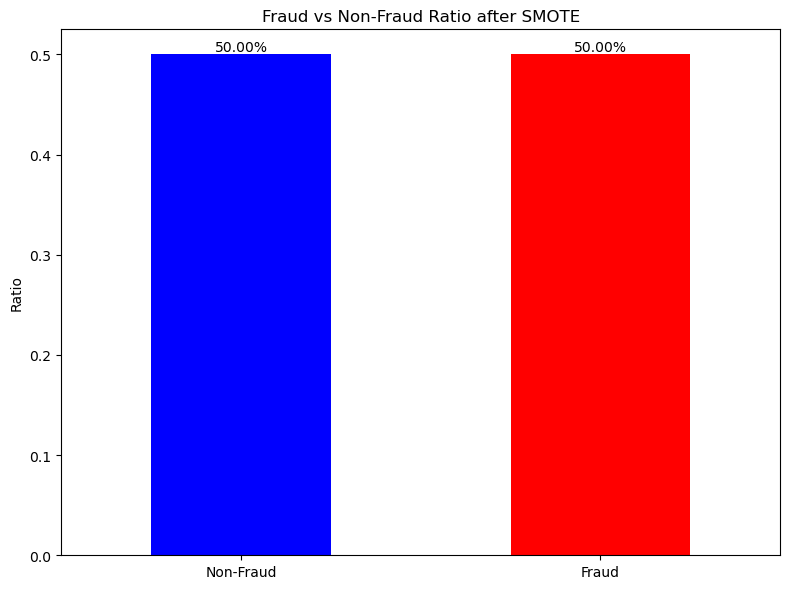

In [20]:
# create a new bar chart of fraud_ratio after SMOTE oversampling
fig, ax = plt.subplots(figsize=(8, 6))

y_train_resampled_ratio.plot(kind='bar', ax=ax, color=['blue', 'red'])

# set labels and title
ax.set_ylabel('Ratio')
ax.set_title('Fraud vs Non-Fraud Ratio after SMOTE')
ax.set_xticklabels(['Non-Fraud', 'Fraud'], rotation=0)

# add percentage labels on the bars
for i, v in enumerate(y_train_resampled_ratio):
    ax.text(i, v, f'{v:.2%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

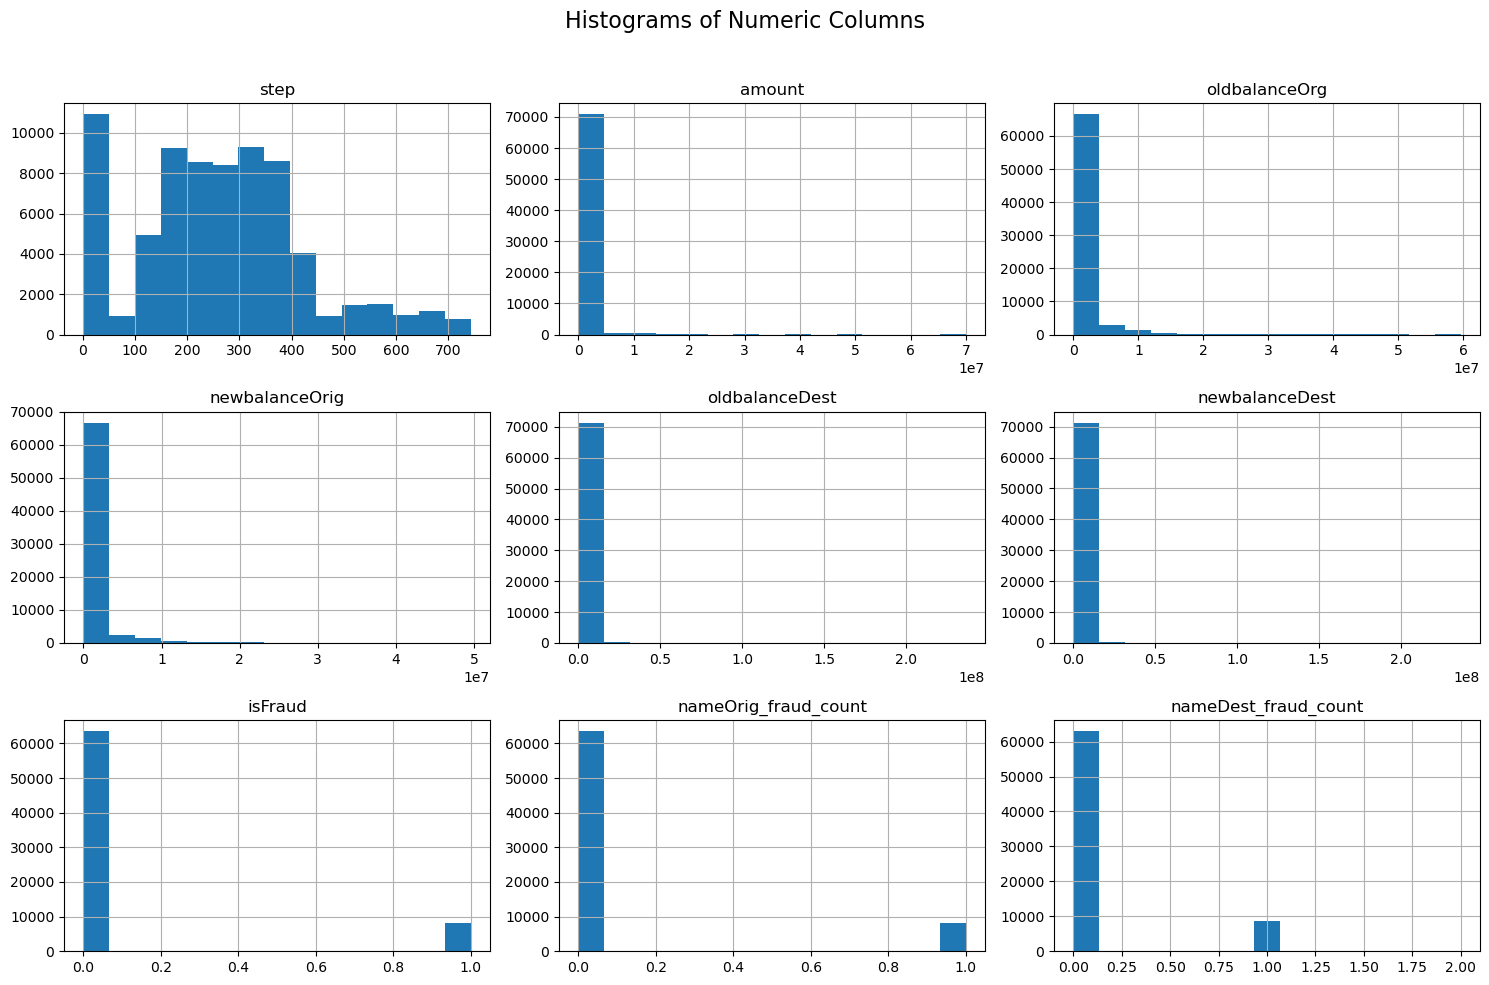

In [21]:
# visualse the distribution of our features
df3.hist(bins=15, figsize=(15, 10))

plt.suptitle('Histograms of Numeric Columns', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

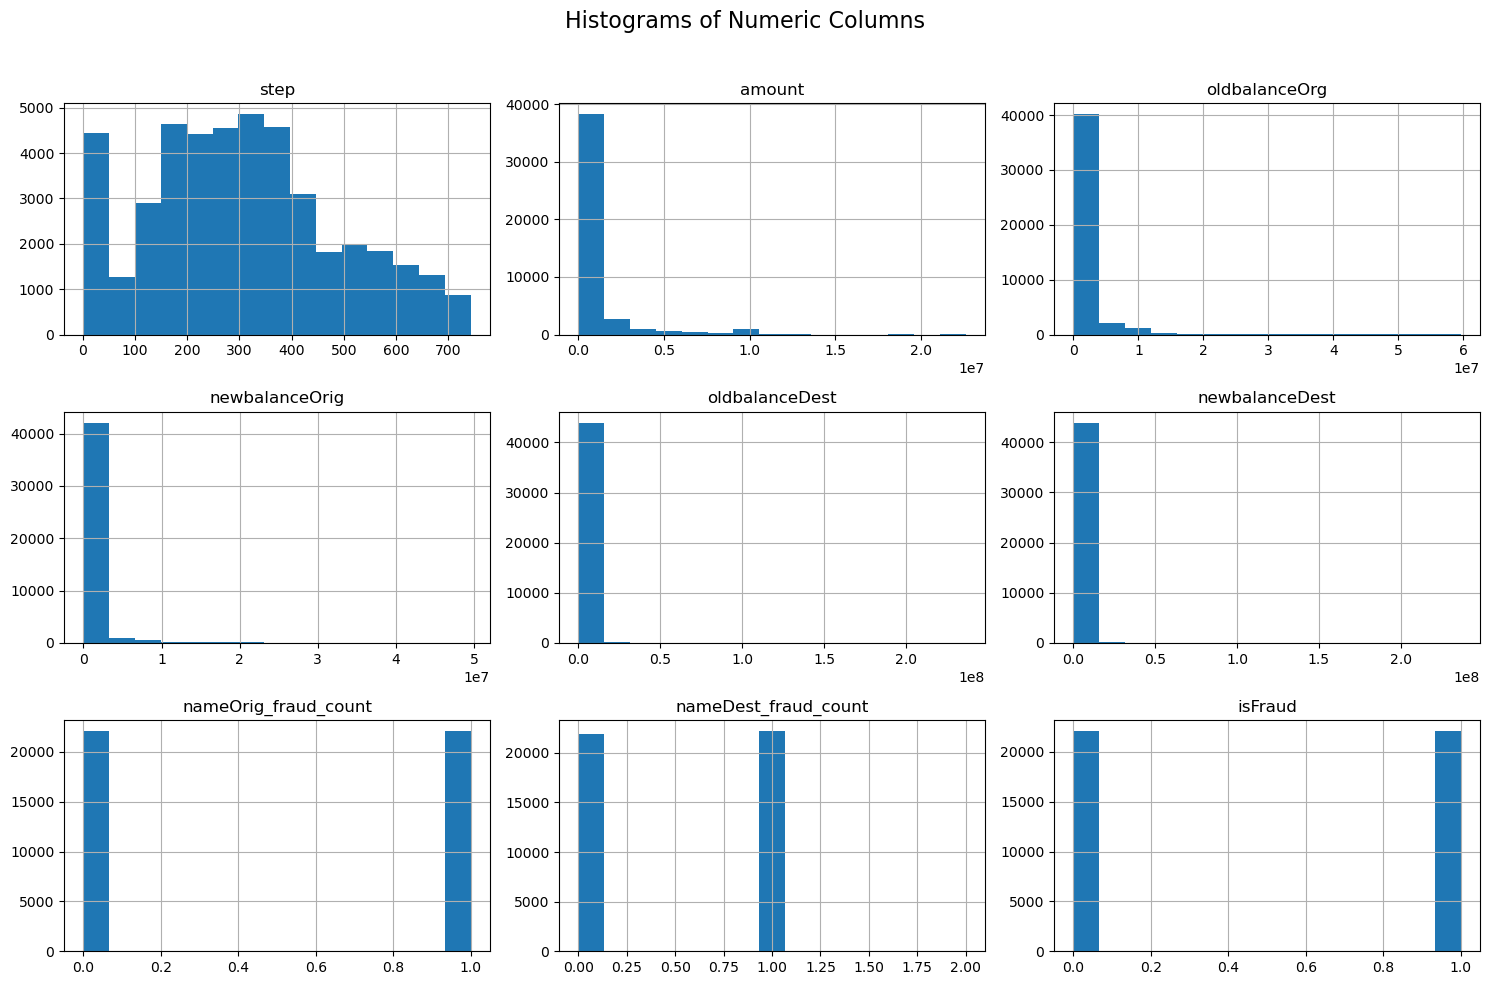

In [22]:
# visualse the distribution of our features after resampling
df_train_resampled.hist(bins=15, figsize=(15, 10))

plt.suptitle('Histograms of Numeric Columns', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

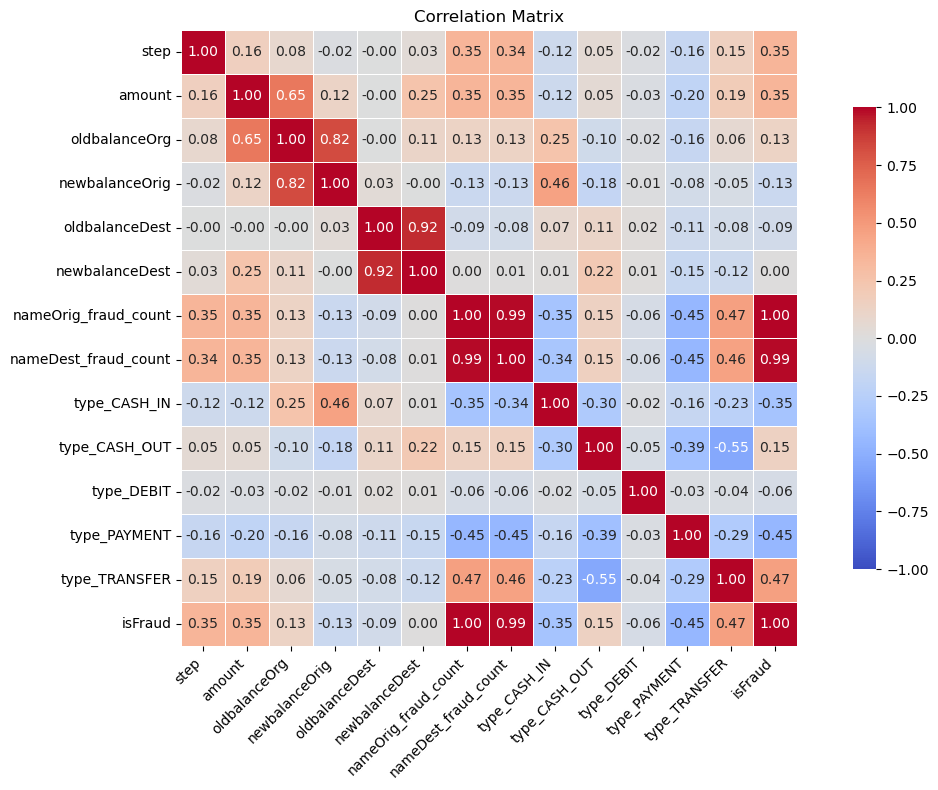

In [23]:
# create correlation matrix
correlation_matrix = df_train_resampled.corr()

# create heatmap of correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix,  annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .75})

plt.title('Correlation Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

Upon further inspection, nameOrig_fraud_count and nameDest_fraud_count have perfect correlations with isFraud because there are no duplicate senders (nameOrig) or recipients (nameDest) where fraud was detected. So when a name in nameOrig is detected as fraud, there is a frequency of 1 in nameOrig_fraud_count, essentially copying isFraud. So, I'll just drop both columns.

In [24]:
# drop columns
df_train_resampled.drop(columns=['nameOrig_fraud_count', 'nameDest_fraud_count'])

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,isFraud
0,395,5.090517e+04,2.120600e+04,0.00,899965.18,950870.35,False,True,False,False,False,0
1,312,9.168560e+04,0.000000e+00,0.00,311092.45,402778.05,False,True,False,False,False,0
2,11,1.360046e+04,0.000000e+00,0.00,65671.00,79271.46,False,True,False,False,False,0
3,35,4.416872e+05,4.226380e+05,0.00,0.00,441687.15,False,True,False,False,False,0
4,250,1.999085e+05,9.164000e+03,209072.49,1346016.25,1146107.76,True,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...
44135,595,3.493465e+05,3.493465e+05,0.00,0.00,0.00,False,False,False,False,True,1
44136,615,6.696540e+06,6.696540e+06,0.00,0.00,0.00,False,False,False,False,True,1
44137,243,4.527799e+06,4.527799e+06,0.00,0.00,0.00,False,False,False,False,True,1
44138,332,1.782745e+05,1.782745e+05,0.00,0.00,0.00,False,False,False,False,True,1


In [25]:
# create a parameter grid for pipeline
parameter_grid = [
    {
        'scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()],
        'PCA': [PCA(n_components=0.95)],
        'model': [LogisticRegression(solver='saga')],
        'model__C': [0.1, 1, 100],
        'model__max_iter': [500, 600, 700]
    },
    {
        'scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()],
        'PCA': [PCA(n_components=0.95)],
        'model': [SVC()],
        'model__C': [0.1, 1, 100],
        'model__kernel': ['linear', 'rbf']
    },
    {
        'scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()],
        'PCA': [PCA(n_components=0.95)],
        'model': [DecisionTreeClassifier()],
        'model__max_depth': [None, 5, 10, 15],
        'model__min_samples_split': [2, 5, 10]
    },
    {
        'scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()],
        'PCA': [PCA(n_components=0.95)],
        'model': [KNN()],
        'model__n_neighbors': [2, 4, 6, 8, 10],
        'model__weights': ['uniform', 'distance']
    },
    {
        'scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()],
        'PCA': [PCA(n_components=0.95)],
        'model': [VotingClassifier(
            estimators=[
                ('lr', LogisticRegression()),
                ('svc', SVC(probability=True)),
                ('dt', DecisionTreeClassifier()),
                ('knn', KNN())
            ]
        )],
        'model__voting': ['hard', 'soft'],
        'model__weights': [None, [1, 1, 1, 1], [2, 1, 1, 1], [1, 2, 1, 1], [1, 1, 2, 1], [1, 1, 1, 2]]
    }
]

In [ ]:
results = []

for params in parameter_grid:
    # store model name as a variable
    model_name = type(params['model'][0]).__name__

    # create Pipeline
    pipeline = Pipeline([
        ('scaler', params['scaler'][0]),
        ('PCA', params['PCA'][0]),
        ('model', params['model'][0])
    ])

    # use RandomizedSearch cross-validation
    n_iter = 10
    random_search = RandomizedSearchCV(pipeline, params, cv=5, scoring='accuracy', n_iter=n_iter, n_jobs=-1, random_state=42)
    random_search.fit(X_train, y_train)

    # get the best model
    best_estimator = random_search.best_estimator_

    # evaluate on the test set
    y_pred = best_estimator.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    results.append({
        'Model': model_name,
        'Best Estimator': best_estimator,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Confusion Matrix': cm
    })

# print results
for result in results:
    print(f"Model: {result['Model']}")
    print(f"Best Estimator: {result['Best Estimator']}")
    print(f"Accuracy: {result['Accuracy']}")
    print(f"Precision: {result['Precision']}")
    print(f"Recall: {result['Recall']}")
    print(f"F1 Score: {result['F1 Score']}")
    print(f"Confusion Matrix:\n{result['Confusion Matrix']}")
    print("----------------------------------------------------")

Model: LogisticRegression
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()), ('PCA', PCA(n_components=0.95)),
                ('model',
                 LogisticRegression(C=0.1, max_iter=700, solver='saga'))])
Accuracy: 0.9044035674470458
Precision: 0.7763819095477387
Recall: 0.19409547738693467
F1 Score: 0.31055276381909547
Confusion Matrix:
[[12671    89]
 [ 1283   309]]
----------------------------------------------------
Model: SVC
Best Estimator: Pipeline(steps=[('scaler', MinMaxScaler()), ('PCA', PCA(n_components=0.95)),
                ('model', SVC(C=0.1, kernel='linear'))])
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
Confusion Matrix:
[[12760     0]
 [    0  1592]]
----------------------------------------------------
Model: DecisionTreeClassifier
Best Estimator: Pipeline(steps=[('scaler', RobustScaler()), ('PCA', PCA(n_components=0.95)),
                ('model',
                 DecisionTreeClassifier(max_depth=15, min_samples_split=10))])
Accuracy: 0.963

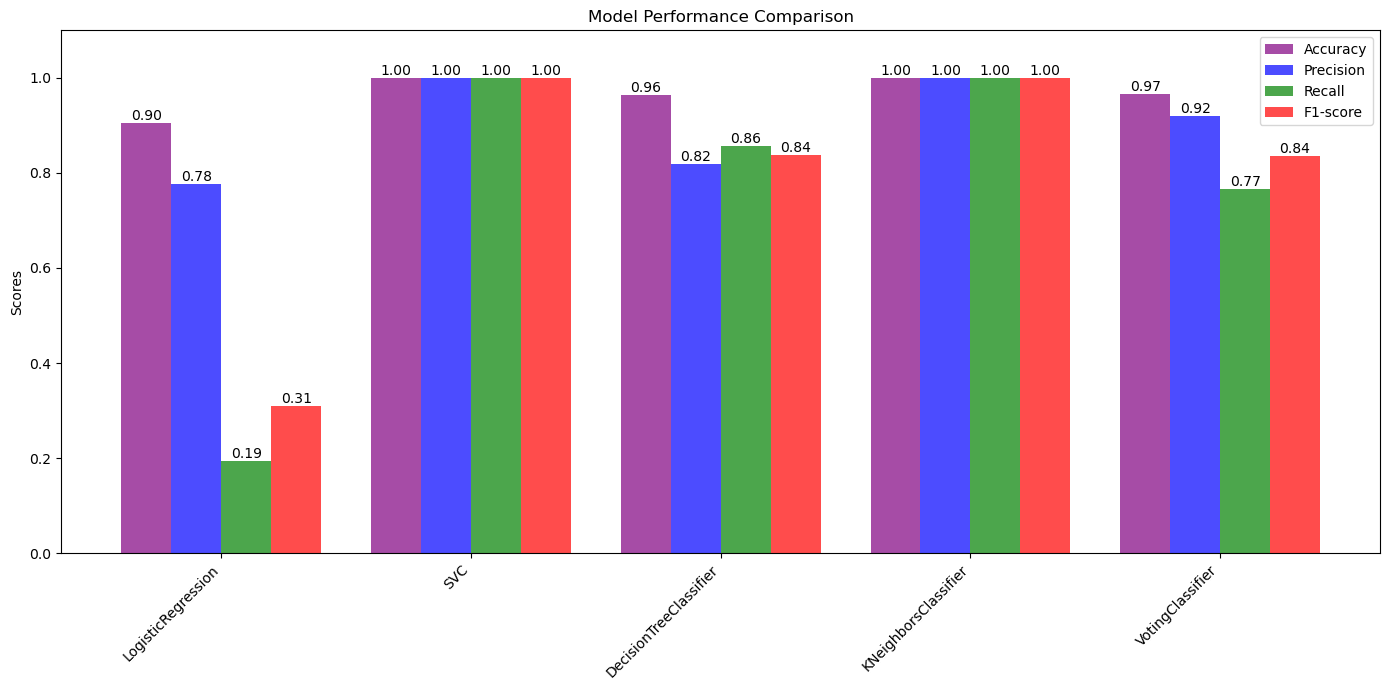

In [28]:

def plot_model_comparison(models, accuracies, precisions, recalls, f1_scores):
    x = np.arange(len(models))
    width = 0.2

    fig, ax = plt.subplots(figsize=(14, 7))
    ax.bar(x - 1.5*width, accuracies, width, label='Accuracy', color='purple', alpha=0.7)
    ax.bar(x - 0.5*width, precisions, width, label='Precision', color='b', alpha=0.7)
    ax.bar(x + 0.5*width, recalls, width, label='Recall', color='g', alpha=0.7)
    ax.bar(x + 1.5*width, f1_scores, width, label='F1-score', color='r', alpha=0.7)

    ax.set_ylabel('Scores')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(models, rotation=45, ha='right')
    ax.legend()

    # Add value labels on the bars
    for i, v in enumerate(accuracies):
        ax.text(i - 1.5*width, v, f'{v:.2f}', ha='center', va='bottom')
    for i, v in enumerate(precisions):
        ax.text(i - 0.5*width, v, f'{v:.2f}', ha='center', va='bottom')
    for i, v in enumerate(recalls):
        ax.text(i + 0.5*width, v, f'{v:.2f}', ha='center', va='bottom')
    for i, v in enumerate(f1_scores):
        ax.text(i + 1.5*width, v, f'{v:.2f}', ha='center', va='bottom')

    plt.ylim(0, 1.1)  # Set y-axis limit to accommodate labels
    plt.tight_layout()
    plt.show()

# Your actual scores
models = ['LogisticRegression', 'SVC', 'DecisionTreeClassifier', 'KNeighborsClassifier', 'VotingClassifier']
accuracies = [0.9044, 1.0000, 0.9632, 1.0000, 0.9668]
precisions = [0.7764, 1.0000, 0.8197, 1.0000, 0.9208]
recalls = [0.1941, 1.0000, 0.8568, 1.0000, 0.7663]
f1_scores = [0.3106, 1.0000, 0.8378, 1.0000, 0.8365]

plot_model_comparison(models, accuracies, precisions, recalls, f1_scores)

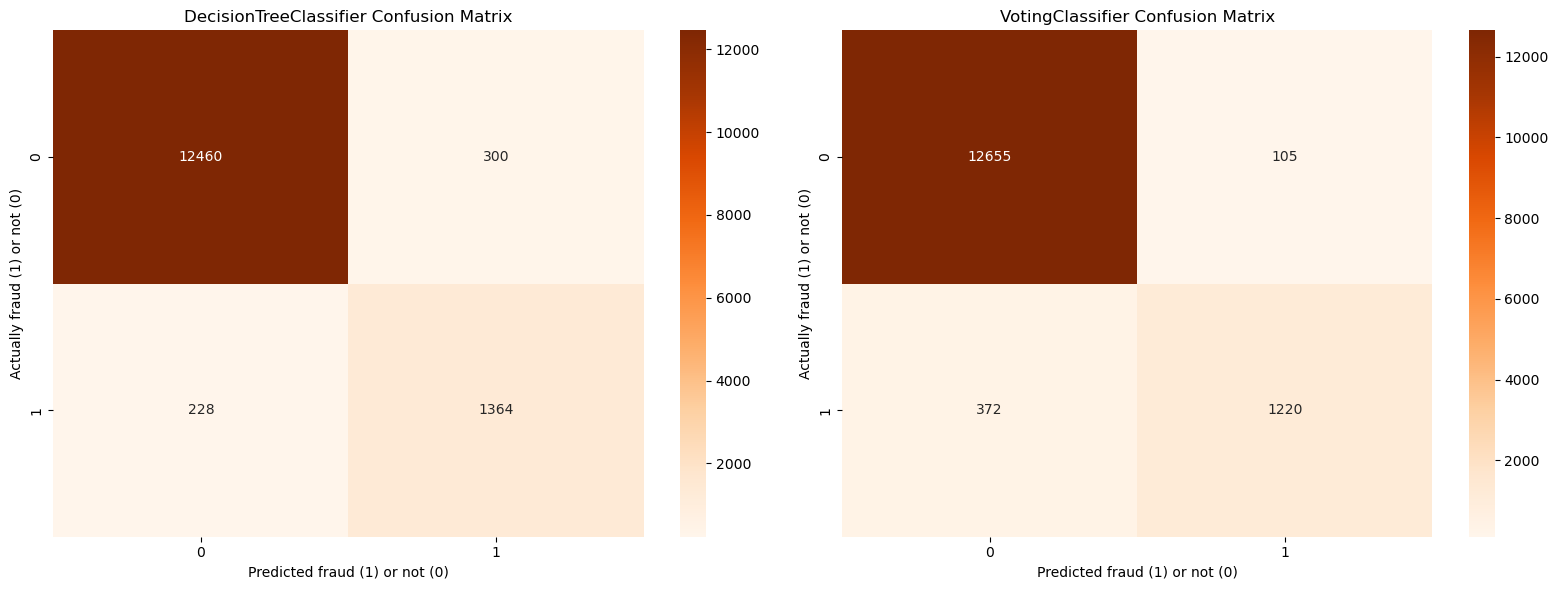

In [36]:
# define plotting function
def plot_confusion_matrices(cm1, cm2, title1, title2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    sns.heatmap(cm1, annot=True, fmt='d', cmap='Oranges', ax=ax1)
    ax1.set_title(title1)
    ax1.set_ylabel('Actually fraud (1) or not (0)')
    ax1.set_xlabel('Predicted fraud (1) or not (0)')
    
    sns.heatmap(cm2, annot=True, fmt='d', cmap='Oranges', ax=ax2)
    ax2.set_title(title2)
    ax2.set_ylabel('Actually fraud (1) or not (0)')
    ax2.set_xlabel('Predicted fraud (1) or not (0)')
    
    plt.tight_layout()
    plt.show()

# create arrays of actual model outputs
cm_decision_tree = np.array([[12460, 300],
                             [228, 1364]])

cm_voting = np.array([[12655, 105],
                      [372, 1220]])

# call plotting function and apply labels
plot_confusion_matrices(cm_decision_tree, cm_voting, 
                        'DecisionTreeClassifier Confusion Matrix', 
                        'VotingClassifier Confusion Matrix')